# Table of Contents

- [Imports](#Imports)
- [Modeling](#Modeling)
- [Preprocessing](#Preprocessing)
- [Baseline](#1---Baseline)
- [Basic CNN](#2---Basic-CNN-Model)
- [VGG16](#3---VGG16-with-added-Dense-layer)
- [VGG16 with Augmented Data](#4---VGG16-with-Data-Augmentation)
- [Evaluation](#Evaluation)

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import urllib
from keras.models import Sequential
from PIL import Image
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
import os, shutil

In [3]:
# specify paths to the directories containing our train and validation images
train_dir = '../picture_data/train'
validation_dir = '../picture_data/validation'

# the output classes we want to predict
classes = ['food', 'culture', 
           'view', 'park']

# Modeling

## Preprocessing

For each class we have 1000 images for training and 300 images for validation. 
We want to generate batches of features and labels to fit the model later. 
The train and validation directories have 1 folder for each class (4 total)
The batch size is set depending on the number of files we train on

In [4]:
# Generate train and validation batches from generator. The input to the VGG16 model has to be of size 
# (224, 224), hence the target size
# each batch is generated from the it's respective subdirectory within the main picture folder
train_batches = ImageDataGenerator().flow_from_directory(train_dir, 
                                                         target_size=(224, 224),
                                                         classes = classes, 
                                                         batch_size = 400)
valid_batches = ImageDataGenerator().flow_from_directory(validation_dir, 
                                                         target_size=(224, 224),
                                                         classes = classes, 
                                                         batch_size = 200)

Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


## 1 - Baseline

Always predicting one class will give us 0.25 accuracy, since they are all equally balanced.
The baseline model would be to always predict that the image belongs to the "food" category

## 2 - Basic CNN Model

Our first model is a typical convolution neural network with 2 blocks of convolution and pooling layers, then flatten to input to a densely connected network, dropout for regularization and a dense output function with 4 nodes (= number of classes)

### Build

In [7]:
# specify layer parameters and activations 
model = Sequential([Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=(2,2)),
                    Flatten(),
                    Dropout(0.5),
                    Dense(4, activation = 'softmax')])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 186624)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 746500    
Total para

### Compile

In [8]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train

In [9]:
history = model.fit_generator(train_batches, 
                              steps_per_epoch = 10, 
                              validation_data = valid_batches, 
                              validation_steps = 6,
                              epochs = 10, 
                              verbose = 1)

Epoch 1/10
10/10 [==============================] - 178s 18s/step - loss: 11.6260 - acc: 0.2588 - val_loss: 12.0682 - val_acc: 0.2500
Epoch 2/10
10/10 [==============================] - 169s 17s/step - loss: 11.9262 - acc: 0.2560 - val_loss: 10.7679 - val_acc: 0.3150
Epoch 3/10
10/10 [==============================] - 169s 17s/step - loss: 10.8489 - acc: 0.3125 - val_loss: 10.7215 - val_acc: 0.3208
Epoch 4/10
10/10 [==============================] - 169s 17s/step - loss: 10.8344 - acc: 0.3140 - val_loss: 10.8659 - val_acc: 0.3142
Epoch 5/10
10/10 [==============================] - 169s 17s/step - loss: 10.8591 - acc: 0.3180 - val_loss: 10.5834 - val_acc: 0.3317
Epoch 6/10
10/10 [==============================] - 169s 17s/step - loss: 10.9112 - acc: 0.3140 - val_loss: 10.4284 - val_acc: 0.3383
Epoch 7/10
10/10 [==============================] - 169s 17s/step - loss: 11.4106 - acc: 0.2880 - val_loss: 11.8708 - val_acc: 0.2583
Epoch 8/10
10/10 [==============================] - 169s 17s/s

### Save

In [24]:
model.save('../data/keras_models/simple_cnn_model.h5')

### Evaluate

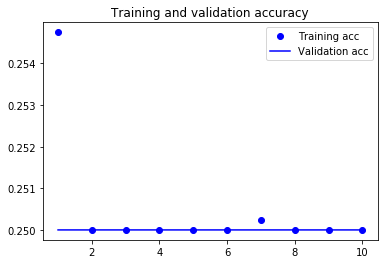

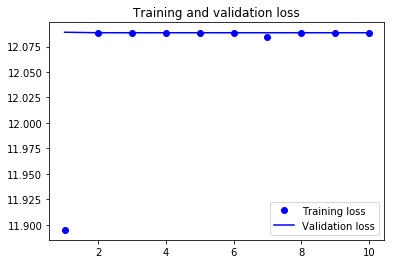

In [25]:
# plot results - source: deep learning with python by Francois Chollet

# get accuracies for each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# get result of loss function for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot accuracies vs epoch for both the train and validation sets
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss vs epoch for both the train and validation sets
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 3 - VGG16 with added Dense layer 

VGG16 is a pre trained model on the ImageNet database for image classification (on 1000 classes). It has been trained for weeks and is very useful to build on top of and not start with random weights.
The simplest way to use VGG16 is to simply replace its output layer with a Dense layer of the shape that we want, the weights of all other layers are frozen (and therefore not trainable). 
Here I also added a Dropout layer for regularization. 
The result is a model with about 135 million parameters, out of which we only train about 16,400.

sources:
- Deep Learning with Python by Francois Chollet
- Keras - Python Deep Learning Neural Network API Youtube Playlist: https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL

### Build

In [15]:
# instantiate VGG16 model
conv_base = VGG16()

# create a blank sequential model
model = Sequential()

# copy all layers from VGG16 except for the last one (since outputs are different)
for layer in conv_base.layers[0:-1]:
    model.add(layer)

# freeze weights in all layers. If we leave them unfrozen, they would be trained. It would still take less time
# than starting at random but we have a lot of parameters here
for layer in model.layers:
    layer.trainable = False

# Add dropout layer for regularization
model.add(Dropout(0.5))  

# Add dense output layer, with 4 classes and softmax activation since we can only output 1 class
model.add(Dense(4, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

### Compile

In [16]:
# compile the model. loss function is categorical crossentropy since we have a multiclassification problem
# the metric used here is accuracy since we want as many predictions as possible to be correct
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train

In [17]:
# Fit the model on train batches and check on validation batches. 
# steps per epoch is the number of images in our training set / batch size = 4000 / 400
# validation steps is the number of images in the validation directory / batch size = 1200 / 200
# we set verbose = 1 to get updates on each epochs with progress bars
history = model.fit_generator(train_batches, 
                              steps_per_epoch = 10, 
                              validation_data = valid_batches, 
                              validation_steps = 6,
                              epochs = 30, 
                              verbose = 1)

Epoch 1/30
10/10 [==============================] - 1198s 120s/step - loss: 2.5648 - acc: 0.2795 - val_loss: 1.7852 - val_acc: 0.3583
Epoch 2/30
10/10 [==============================] - 1164s 116s/step - loss: 2.2834 - acc: 0.3227 - val_loss: 1.5474 - val_acc: 0.4317
Epoch 3/30
10/10 [==============================] - 1165s 116s/step - loss: 2.0616 - acc: 0.3742 - val_loss: 1.4003 - val_acc: 0.4942
Epoch 4/30
10/10 [==============================] - 1165s 116s/step - loss: 1.9077 - acc: 0.4105 - val_loss: 1.3097 - val_acc: 0.5275
Epoch 5/30
10/10 [==============================] - 1174s 117s/step - loss: 1.8009 - acc: 0.4265 - val_loss: 1.2526 - val_acc: 0.5675
Epoch 6/30
10/10 [==============================] - 1164s 116s/step - loss: 1.7245 - acc: 0.4585 - val_loss: 1.2057 - val_acc: 0.5867
Epoch 7/30
10/10 [==============================] - 1164s 116s/step - loss: 1.6257 - acc: 0.4908 - val_loss: 1.1756 - val_acc: 0.5958
Epoch 8/30
10/10 [==============================] - 1165s 116s

### Save

In [18]:
# save the model and the weights to be able to use it later
model.save('../data/keras_models/vgg16_model.h5')

### Evaluate

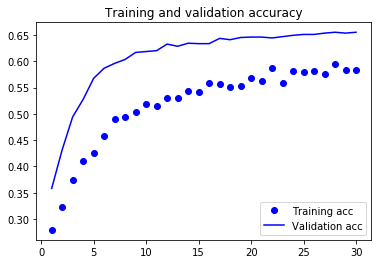

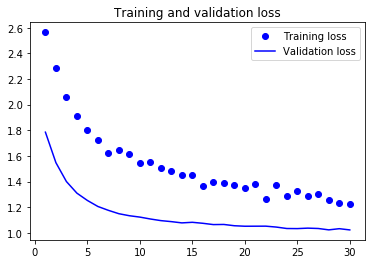

In [19]:
# plot results - source: deep learning with python by Francois Chollet

# get accuracies for each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# get result of loss function for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot accuracies vs epoch for both the train and validation sets
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss vs epoch for both the train and validation sets
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 - VGG16 with Data Augmentation

Data Augmentation is the process of applying various transformations to our input images, so the generator yields modified images. Convolution layers slide through the image and can recognize patterns anywhere in an image but not in any form. The point of the augmented images is that patterns are also transformed and can then be recognized even if they are zoomed in, flipped, rotated etc.

### Preprocessing

In [4]:
# initialize the generators, with inputs of transformations we want to apply
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range = 10,
                                   horizontal_flip=True)

# validation images are not transformed
valid_datagen = ImageDataGenerator()

# generate train batches and validation batches
train_batches = train_datagen.flow_from_directory(train_dir, 
                                                  target_size=(224, 224),
                                                  classes = classes, 
                                                  batch_size = 400)
valid_batches = valid_datagen.flow_from_directory(validation_dir, 
                                                  target_size=(224, 224),
                                                  classes = classes, 
                                                  batch_size = 200)

Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


### Example of an Augmented Image

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


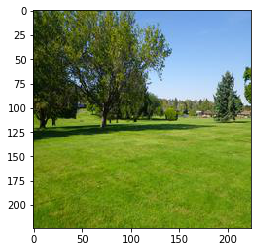

In [5]:
# specify path, photo url (taken online because of Flickr restrictions)
path = '../data/photo_example/park_example.jpg'
url = 'https://yakimaparks.com//assets/Gilbert-Open-Space_2.jpg'

# retrieve photo and resize it
urllib.request.urlretrieve(url, path)
image = Image.open(path)
image = image.resize((224, 224), Image.ANTIALIAS)
image.save(path)

# get the image and show it
image = np.expand_dims(ndimage.imread(path), 0)
plt.imshow(image[0])

In [6]:
# get augmented photos from generator
aug_iter = train_datagen.flow(image)

# create array of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

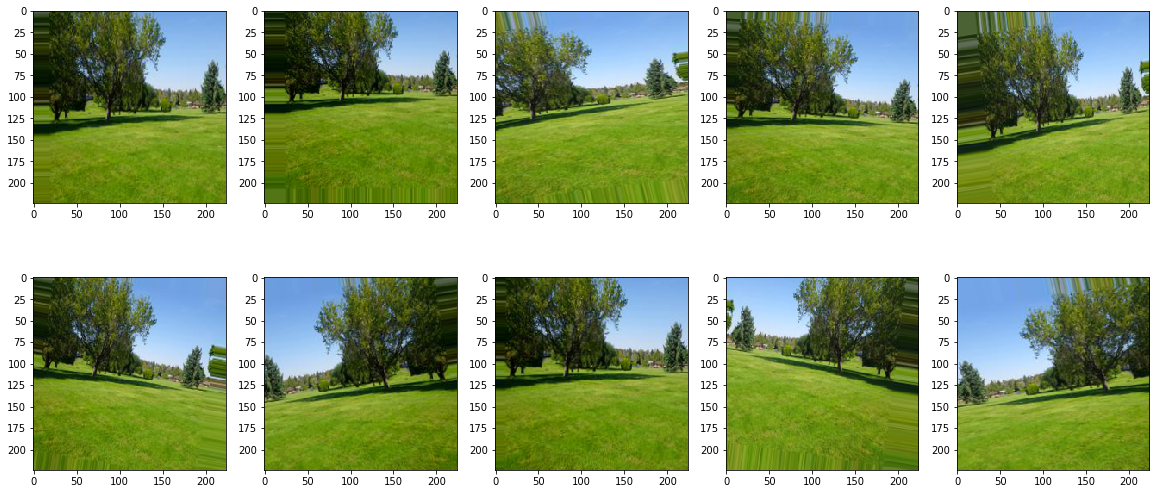

In [8]:
# show all transformed versions of the original image
fig, axes = plt.subplots(nrows= 2, ncols= 5, figsize=(20, 9))
for index in range(len(aug_images)):
    axes[index//5, index%5].imshow(aug_images[index])

### Build

In [9]:
# instantiate VGG16 model
conv_base = VGG16()

# create a blank sequential model
model = Sequential()

# copy all layers from VGG16 except for the last one (since outputs are different)
for layer in conv_base.layers[0:-1]:
    model.add(layer)

# freeze weights in all layers. If we leave them unfrozen, they would be trained. It would still take less time
# than starting at random but we have a lot of parameters here
for layer in model.layers:
    layer.trainable = False

# Add dropout layer for regularization
model.add(Dropout(0.5))  

# Add dense output layer, with 4 classes and softmax activation since we can only output 1 class
model.add(Dense(4, activation='softmax'))
model.summary()

### Compile

In [10]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

### Train

In [12]:
# fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch = 10,
                              epochs = 30,
                              validation_data = valid_batches,
                              validation_steps = 6, 
                              verbose = 1)

Epoch 1/30
10/10 [==============================] - 1244s 124s/step - loss: 2.6312 - acc: 0.2577 - val_loss: 1.8340 - val_acc: 0.3350
Epoch 2/30
10/10 [==============================] - 1215s 122s/step - loss: 2.2973 - acc: 0.3088 - val_loss: 1.5494 - val_acc: 0.4133
Epoch 3/30
10/10 [==============================] - 1209s 121s/step - loss: 2.0783 - acc: 0.3515 - val_loss: 1.3834 - val_acc: 0.4792
Epoch 4/30
10/10 [==============================] - 1207s 121s/step - loss: 1.9214 - acc: 0.4037 - val_loss: 1.2686 - val_acc: 0.5283
Epoch 5/30
10/10 [==============================] - 1204s 120s/step - loss: 1.8025 - acc: 0.4275 - val_loss: 1.2032 - val_acc: 0.5508
Epoch 6/30
10/10 [==============================] - 1207s 121s/step - loss: 1.7175 - acc: 0.4555 - val_loss: 1.1457 - val_acc: 0.5783
Epoch 7/30
10/10 [==============================] - 1207s 121s/step - loss: 1.6172 - acc: 0.4840 - val_loss: 1.1128 - val_acc: 0.6042
Epoch 8/30
10/10 [==============================] - 1210s 121s

### Save

In [13]:
# save it for later use
model.save('../data/keras_models/vgg16_dataaug_model.h5')

### Evaluate

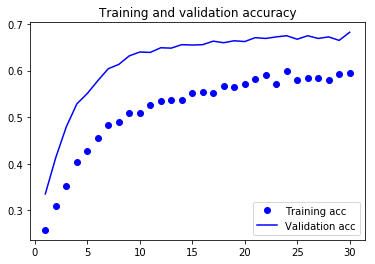

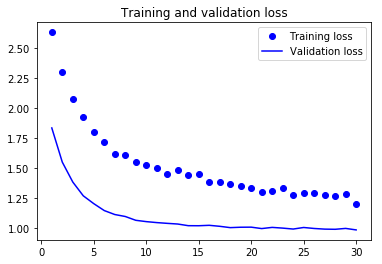

In [14]:
# plot results - source: deep learning with python by Francois Chollet

# get accuracies for each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# get result of loss function for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot accuracies vs epoch for both the train and validation sets
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss vs epoch for both the train and validation sets
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Evaluation

To compare how our models did relative to each other, we can plot a bar graph showing validation accuracy and train accuracy for each model. The baseline here is used as a benchmark so that we can know if our models are an improvement on it.

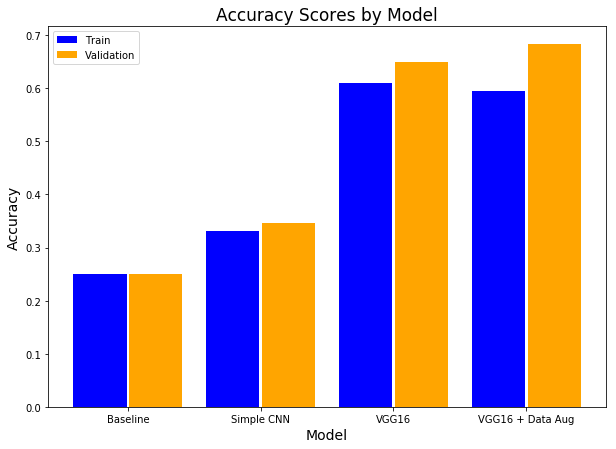

In [10]:
# plot bar chart of accuracy scores of each model
plt.figure(figsize=(10,7))
x = [2, 4, 6, 8]
models = ['Baseline', 'Simple CNN', 'VGG16', 'VGG16 + Data Aug']
# plot bar chart with train accuracies
plt.bar([x_tick-0.42 for x_tick in x], 
        [0.25, 0.331, 0.61, 0.5945], 
        color = 'b')
# add bars with validation accuracies
plt.bar([x_tick+0.42 for x_tick in x], 
        [0.25, 0.3467, 0.65, 0.6825], 
        color = 'orange')
plt.xticks(x, models)
plt.ylabel('Accuracy', size =14)
plt.xlabel('Model', size =14)
plt.title("Accuracy Scores by Model", size =17)
plt.legend(['Train', 'Validation'])
plt.show()